In [2]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

In [3]:
from analysis import analysis, collection
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

image_path = Path("/Users/spencer/phd/phd/images/")

In [4]:
if sys.platform == "linux":
    ROOT_RAWDATA_PATH = Path("/home/spencer/motor-control/data/rawdata/")
    ROOT_METADATA_PATH = Path("/home/spencer/motor-control/data/metadata/")  
else:   
    ROOT_RAWDATA_PATH = Path("/Users/spencer/motor-control/data/rawdata/")
    ROOT_METADATA_PATH = Path("/Users/spencer/motor-control/data/metadata/")

In [5]:
# collection_name = "emg_olympics"
# task_name = "center_hold"
# c = collection.Collection(collection_name)
# subjects = c.alphabetically_sorted_subjects()

In [6]:
# with open('olympics_subjects.pkl', 'wb') as handle:
#     pickle.dump(subjects, handle)

In [7]:
task_name = "center_hold"
with open('olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)
print(len(subjects))

46


## filter: skip first 100 samples, 50th percentile filter per trial, 1-99.9 percentile global

In [22]:
def load_raw_trial_stack(subject):
    # session, target, channel, time
    raw_stack = np.empty(shape=(45, 12, 64, 2000))
    raw_stack[:] = np.nan
    for session_idx, session in enumerate(subject.tasks[task_name].sorted_sessions()[:45]):
        for target_idx in range(1,13):
            for trial in session.sorted_trials():
                if trial.outcome != "No Hold" and trial.target_number == target_idx:
                    e = trial.get_filtered_emg()
                    # trim the beginning of the trial
                    e = e[int(200*trial.hold_time):,:]
                    raw_stack[session_idx, target_idx-1, :, :e.shape[0]] = e.T
    return raw_stack

def load_raw_trajectory_stack(subject):
    trajectory_stack = np.empty(shape=(45, 12, 2, 2000))
    trajectory_stack[:] = np.nan
    for session_idx, session in enumerate(subject.tasks[task_name].sorted_sessions()[:45]):
        for target_idx in range(1,13):
            for trial in session.sorted_trials():
                if trial.outcome != "No Hold" and trial.target_number == target_idx:
                    t = trial.get_trajectory()
                    # trim the beginning of the trial
                    t = t[int(200*trial.hold_time):,:]
                    trajectory_stack[session_idx, target_idx-1, :, :t.shape[0]] = t.T
    return trajectory_stack

def compute_cutoffs(subject_stack):
    # global cutoffs
    assert subject_stack.shape[2] == 64, subject_stack.shape
    samples = analysis.remove_nan_rows(subject_stack.transpose(0,1,3,2).reshape(-1,64))
    lognorms = np.log(np.linalg.norm(samples,axis=1))
    return (np.percentile(lognorms,1), np.percentile(lognorms,99.9))

def find_cutoff_mask(signal,cutoffs):
    # use this with single trials!
    assert signal.shape[1] == 64
    assert signal.shape[0] > signal.shape[1], signal.shape
    assert len(cutoffs) == 2
    log_norm = np.log(np.linalg.norm(signal,axis=1))
    mask = (cutoffs[0] < log_norm) * (log_norm < cutoffs[1])
    return np.arange(signal.shape[0])[mask]

def find_within_trial_mask(signal):
    # within trial values -- 30th percentile of log X
    assert signal.shape[1] == 64
    assert signal.shape[0] > signal.shape[1], signal.shape
    log_norm = np.log(np.linalg.norm(signal,axis=1))
    mean_log_norm = np.mean(log_norm)
    std_log_norm = np.std(log_norm)
    # assuming large samples and rv being lognormal, this is roughly the 30th percentile
    mask = log_norm > (mean_log_norm - 0.0*std_log_norm)
    return np.arange(signal.shape[0])[mask]

def find_trial_filter_indices(signal, cutoffs):
    # combine filters
    assert signal.shape[1] == 64, signal.shape
    assert signal.shape[0] > signal.shape[1], signal.shape
    return np.array([i for i in range(signal.shape[0]) if ((i in find_within_trial_mask(signal)) and (i in find_cutoff_mask(signal, cutoffs)))])

# load and filter the data
def filter_subject_trial_stack(subject_stack):
    assert subject_stack.shape[2] == 64
    assert len(subject_stack.shape) == 4
    # session, target, channel, time
    stack = np.zeros_like(subject_stack)
    stack[:] = np.nan
    # session, target, time
    index_stack = np.zeros(shape=(45,12,2000))
    index_stack[:] = np.nan
    cutoffs = compute_cutoffs(subject_stack)
    for session_idx, session_trials in enumerate(subject_stack):
        for target_idx, e in enumerate(session_trials):
            assert e.shape[0] == 64, e.shape
            assert e.shape[1] > e.shape[0], e.shape
            e_without_nans = analysis.remove_nan_rows(e.T)
            if e_without_nans.shape[0] < e_without_nans.shape[1]:
                print(f"Empty trial: {session_idx,target_idx}")
            else:
                indices = find_trial_filter_indices(e_without_nans,cutoffs)
                e = e[:,indices]
                # stuff this into stack array
                stack[session_idx, target_idx, :, :e.shape[1]] = e
                index_stack[session_idx,target_idx,:indices.shape[0]] = indices
    return stack, index_stack

def load_raw_stack_from_disk(subject_idx):
    return np.load("raw_stacks/raw_stack_" + str(subject_idx) + ".npy")

def load_filtered_stack_from_disk(subject_idx):
    return np.load("filtered_stacks/filtered_stack_" + str(subject_idx) + ".npy")

def load_index_stack_from_disk(subject_idx):
    return np.load("index_stacks/index_stack_" + str(subject_idx) + ".npy")

## test with a single subject

In [46]:
# test with a subject

raw_stack = load_raw_trial_stack(subjects[6])
print(raw_stack.shape)
filtered_stack, index_stack = filter_subject_trial_stack(raw_stack)
print(raw_stack.shape, index_stack.shape)

(45, 12, 64, 2000)
(45, 12, 64, 2000) (45, 12, 2000)


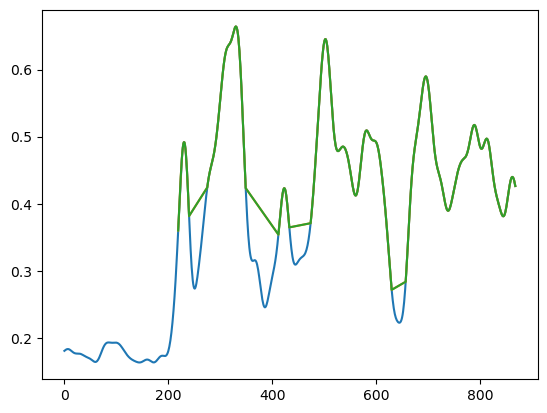

In [49]:
e = raw_stack[0,0,0]
plt.plot(e)
i = analysis.remove_nan_rows(index_stack[0,0].reshape(-1,1))
f = analysis.remove_nan_rows(filtered_stack[0,0,0].reshape(-1,1))
plt.plot(i,f)
plt.plot(i[:,0],raw_stack[0,0,0,i[:,0].astype(int)])

## save each subject's raw trial emg stack

In [13]:
if not Path("raw_stacks").exists():
    Path.mkdir("raw_stacks")

for subject_idx, subject in enumerate(subjects):
    raw_stack = load_raw_trial_stack(subject)
    # write this to disk for later
    np.save("raw_stacks/raw_stack_" + str(subject_idx) + ".npy",raw_stack)
    print(subject_idx, raw_stack.shape)

0 (45, 12, 64, 2000)
1 (45, 12, 64, 2000)
2 (45, 12, 64, 2000)
3 (45, 12, 64, 2000)
4 (45, 12, 64, 2000)
5 (45, 12, 64, 2000)
6 (45, 12, 64, 2000)
7 (45, 12, 64, 2000)
8 (45, 12, 64, 2000)
9 (45, 12, 64, 2000)
10 (45, 12, 64, 2000)
11 (45, 12, 64, 2000)
12 (45, 12, 64, 2000)
13 (45, 12, 64, 2000)
14 (45, 12, 64, 2000)
15 (45, 12, 64, 2000)
16 (45, 12, 64, 2000)
17 (45, 12, 64, 2000)
18 (45, 12, 64, 2000)
19 (45, 12, 64, 2000)
20 (45, 12, 64, 2000)
21 (45, 12, 64, 2000)
22 (45, 12, 64, 2000)
23 (45, 12, 64, 2000)
24 (45, 12, 64, 2000)
25 (45, 12, 64, 2000)
26 (45, 12, 64, 2000)
27 (45, 12, 64, 2000)
28 (45, 12, 64, 2000)
29 (45, 12, 64, 2000)
30 (45, 12, 64, 2000)
31 (45, 12, 64, 2000)
32 (45, 12, 64, 2000)
33 (45, 12, 64, 2000)
34 (45, 12, 64, 2000)
35 (45, 12, 64, 2000)
36 (45, 12, 64, 2000)
37 (45, 12, 64, 2000)
38 (45, 12, 64, 2000)
39 (45, 12, 64, 2000)
40 (45, 12, 64, 2000)
41 (45, 12, 64, 2000)
42 (45, 12, 64, 2000)
43 (45, 12, 64, 2000)
44 (45, 12, 64, 2000)
45 (45, 12, 64, 2000

## filter each raw stack and save the indices

In [40]:
if not Path("filtered_stacks").exists():
    Path.mkdir("filtered_stacks")

if not Path("index_stacks").exists():
    Path.mkdir("index_stacks")

for subject_idx, subject in enumerate(subjects):
    print("Subject ", subject_idx)
    raw_stack = load_raw_stack_from_disk(subject_idx)
    filtered_stack, index_stack = filter_subject_trial_stack(raw_stack)
    print(filtered_stack.shape, index_stack.shape)
    np.save("filtered_stacks/filtered_stack_" + str(subject_idx) + ".npy",filtered_stack)
    np.save("index_stacks/index_stack_" + str(subject_idx) + ".npy",index_stack)

Subject  0
(45, 12, 64, 2000) (45, 12, 2000)
Subject  1
(45, 12, 64, 2000) (45, 12, 2000)
Subject  2
Empty trial: (44, 3)
Empty trial: (44, 6)
Empty trial: (44, 8)
(45, 12, 64, 2000) (45, 12, 2000)
Subject  3
(45, 12, 64, 2000) (45, 12, 2000)
Subject  4
(45, 12, 64, 2000) (45, 12, 2000)
Subject  5
(45, 12, 64, 2000) (45, 12, 2000)
Subject  6
(45, 12, 64, 2000) (45, 12, 2000)
Subject  7
(45, 12, 64, 2000) (45, 12, 2000)
Subject  8
(45, 12, 64, 2000) (45, 12, 2000)
Subject  9
(45, 12, 64, 2000) (45, 12, 2000)
Subject  10
(45, 12, 64, 2000) (45, 12, 2000)
Subject  11
(45, 12, 64, 2000) (45, 12, 2000)
Subject  12
Empty trial: (25, 11)
(45, 12, 64, 2000) (45, 12, 2000)
Subject  13
(45, 12, 64, 2000) (45, 12, 2000)
Subject  14
Empty trial: (0, 7)
Empty trial: (0, 10)
(45, 12, 64, 2000) (45, 12, 2000)
Subject  15
(45, 12, 64, 2000) (45, 12, 2000)
Subject  16
Empty trial: (31, 2)
Empty trial: (31, 5)
Empty trial: (31, 9)
(45, 12, 64, 2000) (45, 12, 2000)
Subject  17
Empty trial: (21, 0)
Empty 

## inspect EMG, filtered, indices

In [48]:
subject_idx = 6
raw_stack = load_raw_stack_from_disk(subject_idx)
filtered_stack = load_filtered_stack_from_disk(subject_idx)
index_stack = load_index_stack_from_disk(subject_idx)

In [49]:
index_stack.shape

(45, 12, 2000)

(2000, 64)
(64, 2000)
(696, 1)


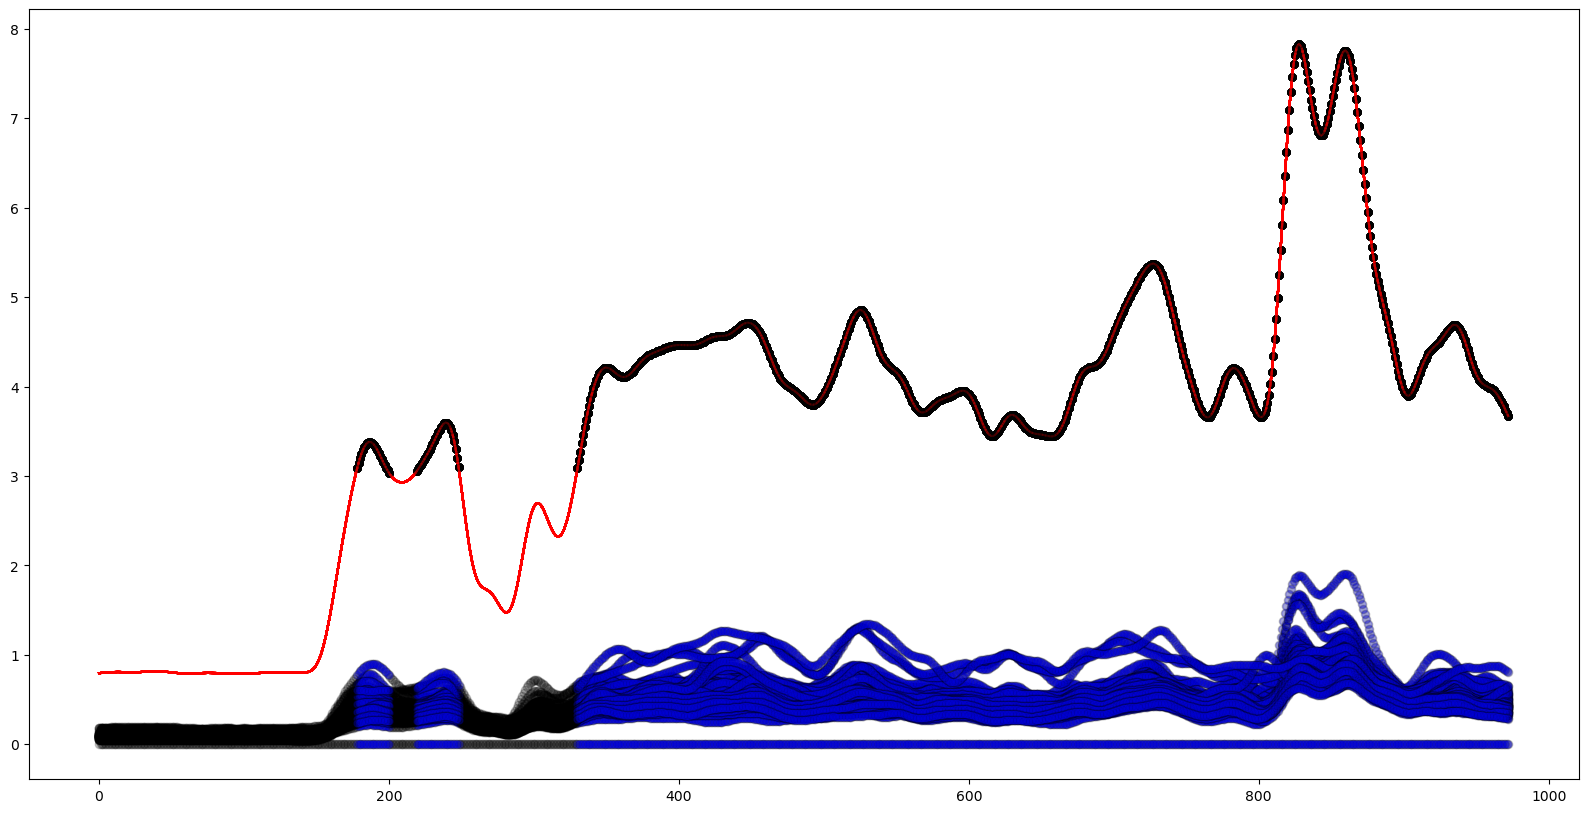

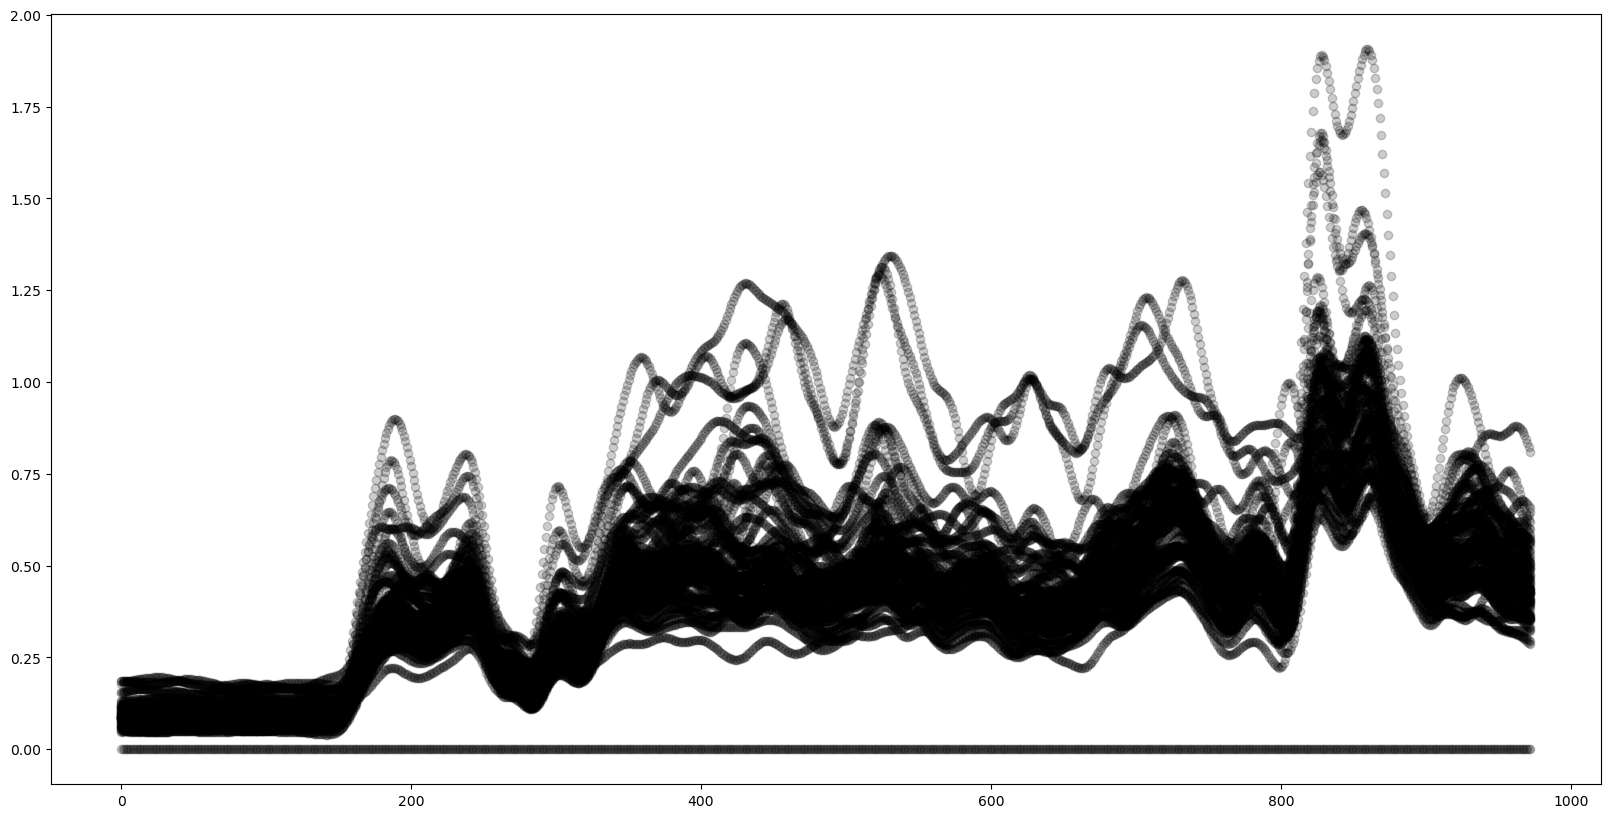

In [50]:
session_idx = 1
target_idx = 1

e = raw_stack[session_idx,target_idx].T
print(e.shape)
f = filtered_stack[session_idx,target_idx]
print(f.shape)
indices = analysis.remove_nan_rows(index_stack[session_idx,target_idx].reshape(-1,1)).astype(int)
print(indices.shape)

plt.figure(figsize=(20,10))
for ch in range(0,64):
    plt.plot(e[:,ch],'ko',alpha=0.2)
    plt.plot(indices, e[indices,ch],'bo',alpha=0.2,markersize=5)
    plt.plot(np.linalg.norm(e,axis=1),"r",)
    plt.plot(indices,np.linalg.norm(e,axis=1)[indices],"ko",alpha=0.2,markersize=5)
plt.figure(figsize=(20,10))
for ch in range(0,64):
    plt.plot(raw_stack[session_idx,target_idx,ch],'ko',alpha=0.2)

## save raw and filtered trajectories

In [65]:
raw_trajectory_stacks = np.zeros(shape=(46,45,12,2,2000))
raw_trajectory_stacks[:] = np.nan
filtered_trajectory_stacks = np.zeros_like(raw_trajectory_stacks)
filtered_trajectory_stacks[:] = np.nan

for subject_idx, subject in enumerate(subjects):
    print("Subject ", subject_idx)
    raw_trajectory_stack = load_raw_trajectory_stack(subject)
    raw_trajectory_stacks[subject_idx] = raw_trajectory_stack
    index_stack = load_index_stack_from_disk(subject_idx)
    for session_idx, session in enumerate(raw_trajectory_stack):
        for target_idx, trial in enumerate(session):
            indices = analysis.remove_nan_rows(index_stack[session_idx,target_idx].reshape(-1,1))
            filtered_trajectory = trial[:,indices.reshape(-1).astype(int)]
            filtered_trajectory_stacks[subject_idx,session_idx,target_idx,:,:indices.shape[0]] = filtered_trajectory
print(raw_trajectory_stacks.shape)

Subject  0
Subject  1
Subject  2
Subject  3
Subject  4
Subject  5
Subject  6
Subject  7
Subject  8
Subject  9
Subject  10
Subject  11
Subject  12
Subject  13
Subject  14
Subject  15
Subject  16
Subject  17
Subject  18
Subject  19
Subject  20
Subject  21
Subject  22
Subject  23
Subject  24
Subject  25
Subject  26
Subject  27
Subject  28
Subject  29
Subject  30
Subject  31
Subject  32
Subject  33
Subject  34
Subject  35
Subject  36
Subject  37
Subject  38
Subject  39
Subject  40
Subject  41
Subject  42
Subject  43
Subject  44
Subject  45
(46, 45, 12, 2, 2000)


In [135]:
np.save("subject_raw_trajectory_stacks.npy", raw_trajectory_stacks)
del raw_trajectory_stacks

np.save("subject_filtered_trajectory_stacks.npy", filtered_trajectory_stacks)
del filtered_trajectory_stacks

subject_raw_trajectory_stacks = np.load("subject_raw_trajectory_stacks.npy")
print(subject_raw_trajectory_stacks.shape)

subject_filtered_trajectory_stacks = np.load("subject_filtered_trajectory_stacks.npy")
print(subject_filtered_trajectory_stacks.shape)

(46, 45, 12, 2, 2000)
(46, 45, 12, 2, 2000)


## inspect trajectory

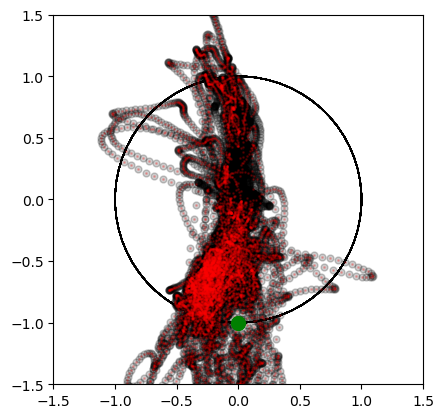

In [139]:
subject_idx = 43
target_idx = 9
target_vec = collection.compute_target_vec_from_number(target_idx+1)

for session_idx in range(45):
    t = subject_raw_trajectory_stacks[subject_idx,session_idx,target_idx]
    plt.plot(t[0],t[1],"ko",alpha=0.2,markersize=5)
    l = 2
    plt.plot([-l,-l,l,l,-l],[-l,l,l,-l,-l],'k')
    c = plt.Circle([0,0],1,color="k",fill=None)
    plt.gca().add_patch(c)

for session_idx in range(45):
    tf = subject_filtered_trajectory_stacks[subject_idx,session_idx,target_idx]
    plt.plot(tf[0],tf[1],"ro",alpha=0.2,markersize=1)

plt.plot(target_vec[0],target_vec[1],"go",markersize=10)
plt.ylim([-1.5,1.5])
plt.xlim([-1.5,1.5])
plt.gca().set_aspect("equal")

## inspect histograms

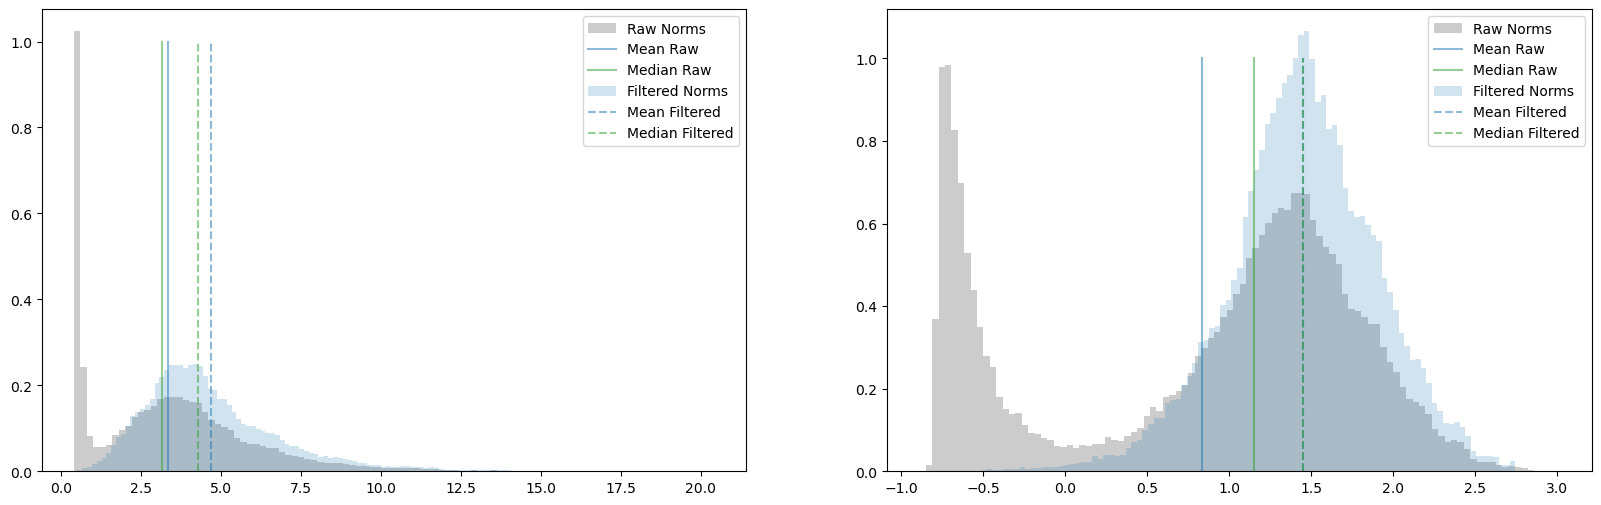

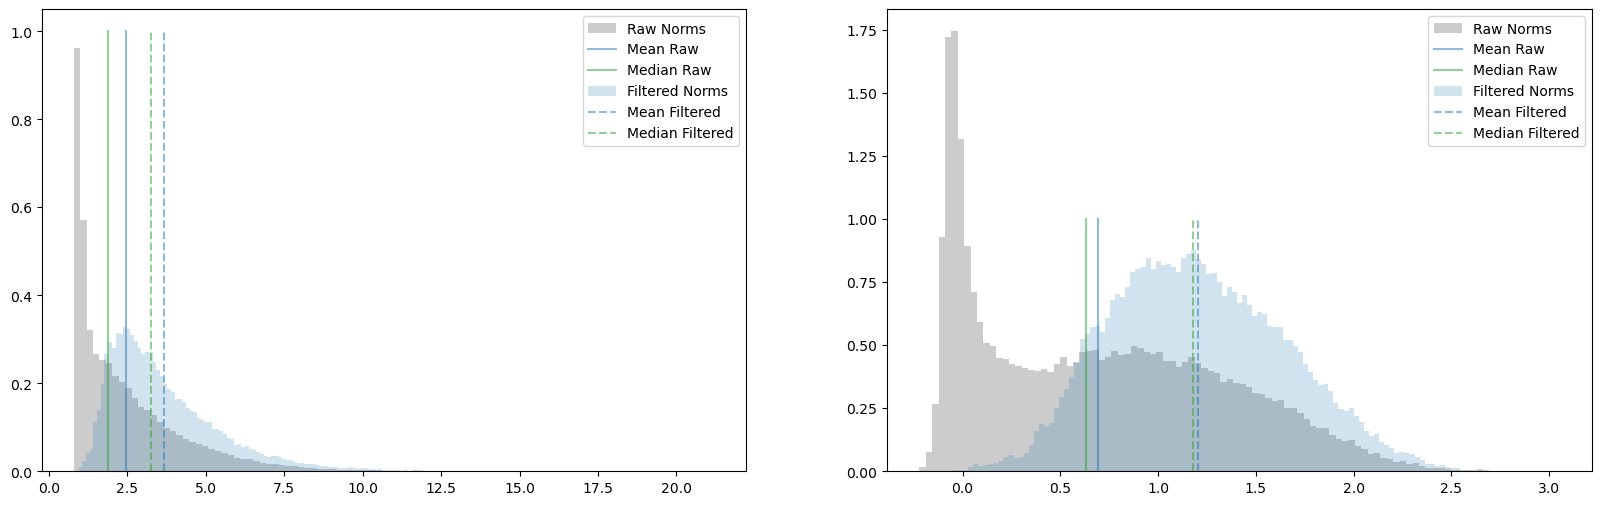

In [141]:
def plot_stats(signal, ax, linestyle="-", label=""):
    mean = np.mean(signal)
    ax.plot([mean, mean], [0,1],'tab:blue',linestyle=linestyle,label="Mean" + label,alpha=0.5)
    median = np.median(signal)
    ax.plot([median, median], [0,1],'tab:green',linestyle=linestyle,label="Median" + label,alpha=0.5)


for subject_idx in range(len(subjects[23:25])):
    fig, axes = plt.subplots(1,2,figsize=(20,6))

    raw_stack = load_raw_stack_from_disk(subject_idx)
    filtered_stack = load_filtered_stack_from_disk(subject_idx)

    raw_samples = analysis.remove_nan_rows(raw_stack.transpose(0,1,3,2).reshape(-1,64))
    filtered_samples = analysis.remove_nan_rows(filtered_stack.transpose(0,1,3,2).reshape(-1,64))

    raw_norms = np.linalg.norm(raw_samples,axis=1)
    filtered_norms = np.linalg.norm(filtered_samples,axis=1)
    raw_log_norms = np.log(np.linalg.norm(raw_samples,axis=1))
    filtered_log_norms = np.log(np.linalg.norm(filtered_samples,axis=1))

    # sample norms
    axes[0].hist(raw_norms,color="k",density=True,alpha=0.2,bins=100,label="Raw Norms")
    plot_stats(raw_norms, axes[0],label=" Raw")
    # filtered norms
    axes[0].hist(filtered_norms,color="tab:blue",density=True,alpha=0.2,bins=100,label="Filtered Norms")
    plot_stats(filtered_norms,axes[0],linestyle="--",label=" Filtered")
    axes[0].legend()

    # sample norms
    axes[1].hist(raw_log_norms,color="k",density=True,alpha=0.2,bins=100,label="Raw Norms")
    plot_stats(raw_log_norms, axes[1],label=" Raw")
    # filtered norms
    axes[1].hist(filtered_log_norms,color="tab:blue",density=True,alpha=0.2,bins=100,label="Filtered Norms")
    plot_stats(filtered_log_norms,axes[1],linestyle="--",label=" Filtered")


    axes[1].legend()
